# Exampled EDA

I'm going to copy Guille's EDA from previous module (module_2) to keep it in the repository

In [ ]:
import boto3
import os
from dotenv import load_dotenv
from botocore.exceptions import ClientError
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

In [80]:
data = pd.read_csv(r"/home/raquel/zrive-ds/src/module_3/feature_frame.csv")

In [81]:
data.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

In [82]:
data.shape

(2880549, 27)

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [101]:
data.isnull().sum().sum()

0

In [100]:
target_counts = data["outcome"].value_counts(normalize=True)
print(target_counts)
target_counts2 = data["outcome"].value_counts()
print(target_counts2)

outcome
0.0    0.988463
1.0    0.011537
Name: proportion, dtype: float64
outcome
0.0    2847317
1.0      33232
Name: count, dtype: int64


In [102]:
# Sin poder predictivo
info_cols = ["variant_id", "order_id", "user_id", "created_at", "order_date"]
label_col = "outcome"
feature_cols = [col for col in data.columns if col not in info_cols + [label_col]]
# Desgrano las features
categorical_cols = ["product_type", "vendor"]
binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]
numerical_cols = [
    col for col in feature_cols if col not in categorical_cols + binary_cols
]

In [123]:
# Proporción de 1s y 0s en las variables binarias
# Efecto de ambas en la etiqueta
for col in binary_cols:
    print(f"Value counts {col}: {data[col].value_counts().to_dict()}")
    print(
        f"Mean outcome by {col} value: {data.groupby(col)['outcome'].mean().to_dict()}"
    )

Value counts ordered_before: {0.0: 2819658, 1.0: 60891}
Mean outcome by ordered_before value: {0.0: 0.008223337723936732, 1.0: 0.1649669080816541}
Value counts abandoned_before: {0.0: 2878794, 1.0: 1755}
Mean outcome by abandoned_before value: {0.0: 0.011106039542947498, 1.0: 0.717948717948718}
Value counts active_snoozed: {0.0: 2873952, 1.0: 6597}
Mean outcome by active_snoozed value: {0.0: 0.011302554809544488, 1.0: 0.1135364559648325}
Value counts set_as_regular: {0.0: 2870093, 1.0: 10456}
Mean outcome by set_as_regular value: {0.0: 0.010668992259135854, 1.0: 0.24971308339709258}


Interpretación:
Si un producto está guardado en regulares, hay un 24% de probabilidades de que se compre.
Si un producto fue abandonado antes, hay un 71% de probabilidades de que se compre.
Pero están extremadamente desbalanceadas (sobre todo abandoned,snoozed, regular) que quizás podrían eliminarse o crear una meta feature que represente a las 4.

Además, se ve como todas estas variables binarias están fuertemente relacionadas con outcome. En especial, abandoned_before = 1 está altamente alineada con outcome aunque es muy "sparse" y apenas toma valores positivos.

<Axes: >

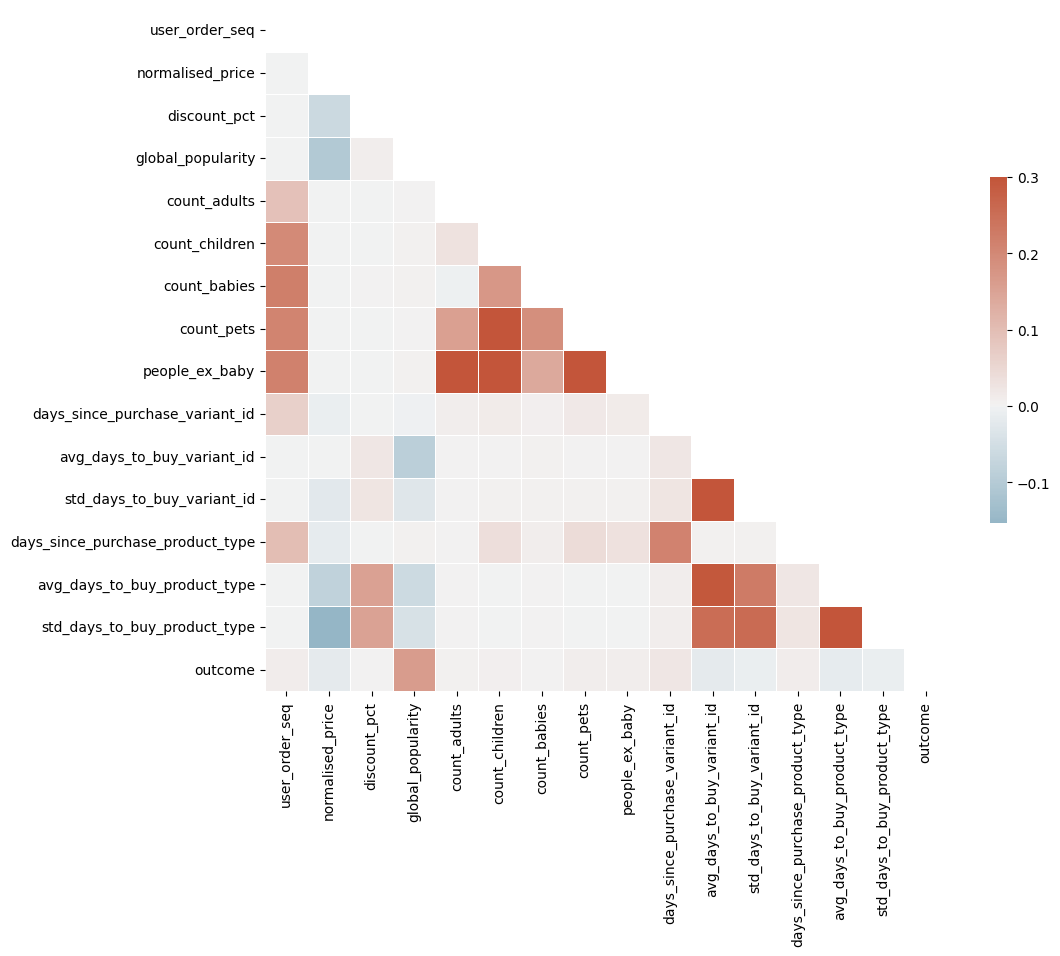

In [131]:
# Correlación de las variables numéricas
corr = data[numerical_cols + [label_col]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

Algunas variables numéricas están moderadamente correladas. Algo para tener en cuenta si utilizamos modelos donde la colinearidad pueda ser importante.

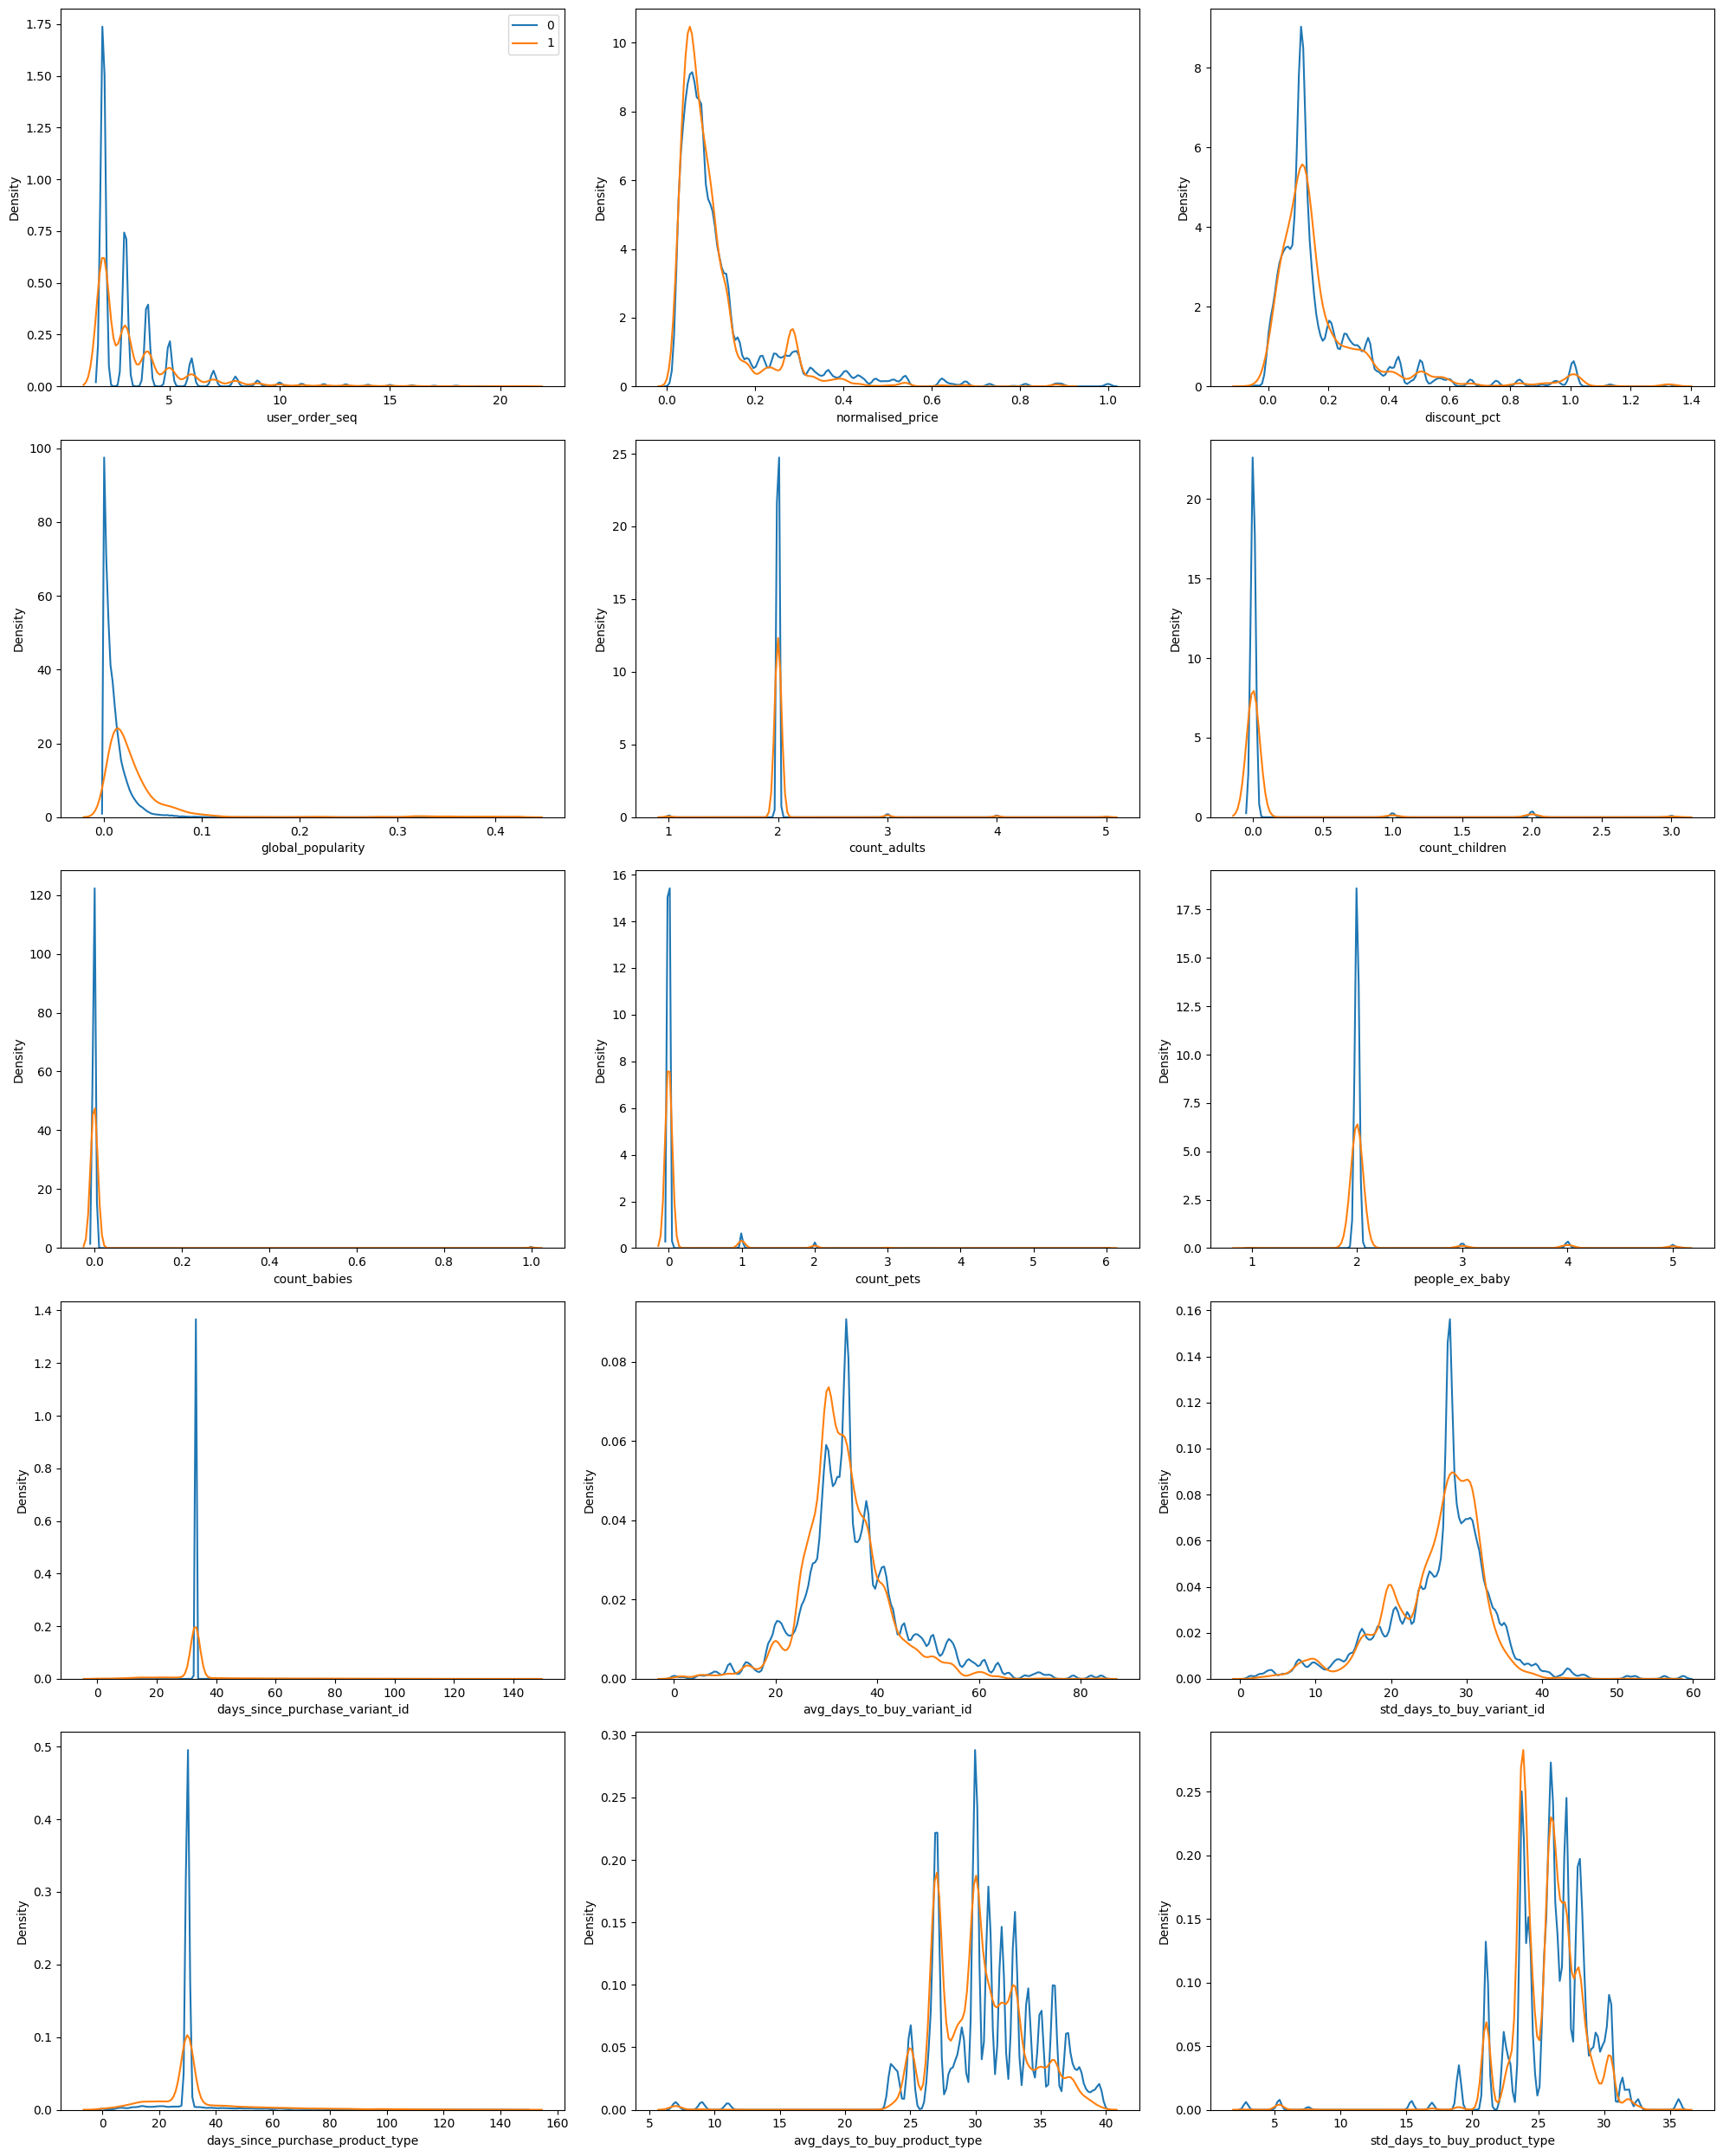

In [132]:
# Las pinto para las dos variables para ver si hay alguna variable que tenga una distribución muy distinta para
# una que para otra
cols = 3
rows = int(np.ceil(len(numerical_cols) / cols))
fig, ax = plt.subplots(rows, cols, figsize=(20, 5 * rows))
ax = ax.flatten()

for i, col in enumerate(numerical_cols):
    sns.kdeplot(data.loc[lambda x: x.outcome == 0, col], label="0", ax=ax[i])
    sns.kdeplot(data.loc[lambda x: x.outcome == 1, col], label="1", ax=ax[i])

ax[0].legend()
plt.tight_layout()

En la popularidad: los productos que se compran tienen una popularidad mayor que los productos que no se compran
Count adults: todos tienen 2
Porcentaje de descuento: los productos que no se compran tienen mas descuento

In [133]:
# Categorical encoding
data[categorical_cols].describe()

,product_type,vendor
count,2880549,2880549
unique,62,264
top,tinspackagedfoods,biona
freq,226474,146828


Como la cardinalidad de las categóricas es muy elevada las olvido y estudio con el pipeline creado a ver si alguna aporta. Barajar frequency encoding